### Plot cell type annotation confusion matrix between symphony and manual

In [262]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
from sklearn.metrics import confusion_matrix
import seaborn as sns
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [263]:
# Load data
dataPath = '../../../results'

# manual annotation
manual_liver = ad.read_h5ad(os.path.join(dataPath, 'MERFISH_liver_object.h5ad'))
manual_kidney = ad.read_h5ad(os.path.join(dataPath, 'MERFISH_kidney_object.h5ad'))

# symphony integration
symphony_liver = pd.read_csv(os.path.join(dataPath, 'symphony', 'VizgenLiver_symphony_query.csv'))
symphony_kidney = pd.read_csv(os.path.join(dataPath, 'symphony', 'VizgenKidney_symphony_query.csv'))

# Set symphony indices and convert symphony indices to strings to match the manual annotation dataframe
symphony_liver = symphony_liver.set_index('Unnamed: 0')
symphony_kidney = symphony_kidney.set_index('Unnamed: 0')
symphony_liver.index = symphony_liver.index.astype(str)
symphony_kidney.index = symphony_kidney.index.astype(str)

print('Data loaded.')

Data loaded.


In [264]:
# Create dataframe to compare cell type annotations

# liver
annot_liver = pd.DataFrame(index = manual_liver.obs.index)
annot_liver['manual'] = manual_liver.obs['free_annotation']
annot_liver['symphony'] = symphony_liver['cell_type_pred_knn']

# kidney
annot_kidney = pd.DataFrame(index = manual_kidney.obs.index)
annot_kidney['manual'] = manual_kidney.obs['free_annotation']
annot_kidney['symphony'] = symphony_kidney['cell_type_pred_knn']

In [265]:
# Remap kidney annotations
fileName = '/mnt/ibm_lg/spatial-seq/vizgen-MACA-comparison-paper/results/mousekidney_celltype_relabeling - final.csv'
df_relabel = pd.read_csv(fileName)

# Create dictionary from dataframe
kidneymap = pd.Series(df_relabel['Cell ontology relabel'].values, index=df_relabel['MACA']).to_dict()

# Relabel annotations
annot_kidney['symphony'] = annot_kidney['symphony'].map(kidneymap)

# Replace 'kidney cell' with nan
annot_kidney['symphony'] = annot_kidney['symphony'].replace('kidney cell', np.nan)

print('Kidney data re-annotated and cleaned up.')

Kidney data re-annotated and cleaned up.


In [266]:
# Remap cell type labels to coarse groups
liver_relabel_map = {'B cell': 'immune cell',
                    'NK cell': 'immune cell',
                    'periportal endothelial cell': 'periportal endothelial cell',
                    'pericentral endothelial cell': 'pericentral endothelial cell',
                    'other endothelial cell': 'other endothelial cell',
                    'myeloid leukocyte': 'immune cell',
                    'plasmacytoid dendritic cell': 'immune cell',
                    'Kupffer cell': 'Kupffer cell',
                    'hepatic stellate cell': 'hepatic stellate cell',
                    'other hepatocyte': 'other hepatocyte',
                    'periportal hepatocyte': 'periportal hepatocyte',
                    'pericentral hepatocyte': 'pericentral hepatocyte'}
kidney_relabel_map = {'macrophage': 'immune cell',
                     'lymphocyte': 'immune cell',
                     'glomerular capillary endothelial cell': 'endothelial cell',
                     'kidney blood vessel cell': 'endothelial cell',
                     'plasma cell': 'immune cell',
                     'epithelial cell of proximal tubule': 'epithelial cell of proximal tubule',
                     'kidney loop of Henle epithelial cell': 'kidney loop of Henle epithelial cell',
                     'kidney distal convoluted tubule epithelial cell': 'kidney distal convoluted tubule epithelial cell',
                     'kidney collecting duct epithelial cell': 'kidney collecting duct epithelial cell',
                     'pericyte': 'pericyte',
                     'podocyte': 'podocyte',
                     'fibroblast': 'fibroblast'}

annot_liver['symphony'] = annot_liver['symphony'].map(liver_relabel_map)
annot_kidney['symphony'] = annot_kidney['symphony'].map(kidney_relabel_map)

# Create abbreviated cell type labels
liver_abbrev_map = {'immune cell': 'IC',
                   'other endothelial cell': 'o-EC',
                   'Kupffer cell': 'KC',
                   'hepatic stellate cell': 'HSC',
                   'other hepatocyte': 'o-hep',
                   'periportal hepatocyte': 'PP-hep',
                   'pericentral hepatocyte': 'PC-hep',
                   'periportal endothelial cell': 'PP-EC',
                   'pericentral endothelial cell': 'PC-EC',
                   'bile duct epithelial cell': 'BD-EC'}
kidney_abbrev_map = {'epithelial cell of proximal tubule':'EC-PT',
                    'immune cell': 'IC',
                    'pericyte':'per',
                    'kidney loop of Henle epithelial cell':'KLH-EC',
                    'kidney collecting duct epithelial cell':'KCD-EC',
                    'kidney distal convoluted tubule epithelial cell':'KDCT-EC',
                    'endothelial cell': 'EC',
                    'podocyte':'pod',
                    'fibroblast':'fib'}

annot_liver['manual_abv'] = annot_liver['manual'].map(liver_abbrev_map).astype(str)
annot_liver['symphony_abv'] = annot_liver['symphony'].map(liver_abbrev_map).astype(str)
annot_kidney['manual_abv'] = annot_kidney['manual'].map(kidney_abbrev_map).astype(str)
annot_kidney['symphony_abv'] = annot_kidney['symphony'].map(kidney_abbrev_map).astype(str)

# Add labels to AnnData object
manual_liver.obs['free_annotation_abv'] = annot_liver['manual_abv']
manual_liver.obs['symphony_annotation_abv'] = annot_liver['symphony_abv']
manual_kidney.obs['free_annotation_abv'] = annot_kidney['manual_abv']
manual_kidney.obs['symphony_annotation_abv'] = annot_kidney['symphony_abv']

# Drop the cells labeled with nan
annot_kidney = annot_kidney.dropna()

# Remove kidney cells that are labeled as nan
manual_kidney = manual_kidney[manual_kidney.obs['symphony_annotation_abv'] != 'nan']



print('Cell type labels remapped and abbreviated.')

Cell type labels remapped and abbreviated.


In [267]:
# Rotate liver coordinates to make plotting nicer
manual_liver.obsm['spatial'] = manual_liver.obsm['spatial'][:,[1,0]].copy()

/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


[<AxesSubplot:title={'center':'symphony_annotation_abv'}, xlabel='spatial1', ylabel='spatial2'>]

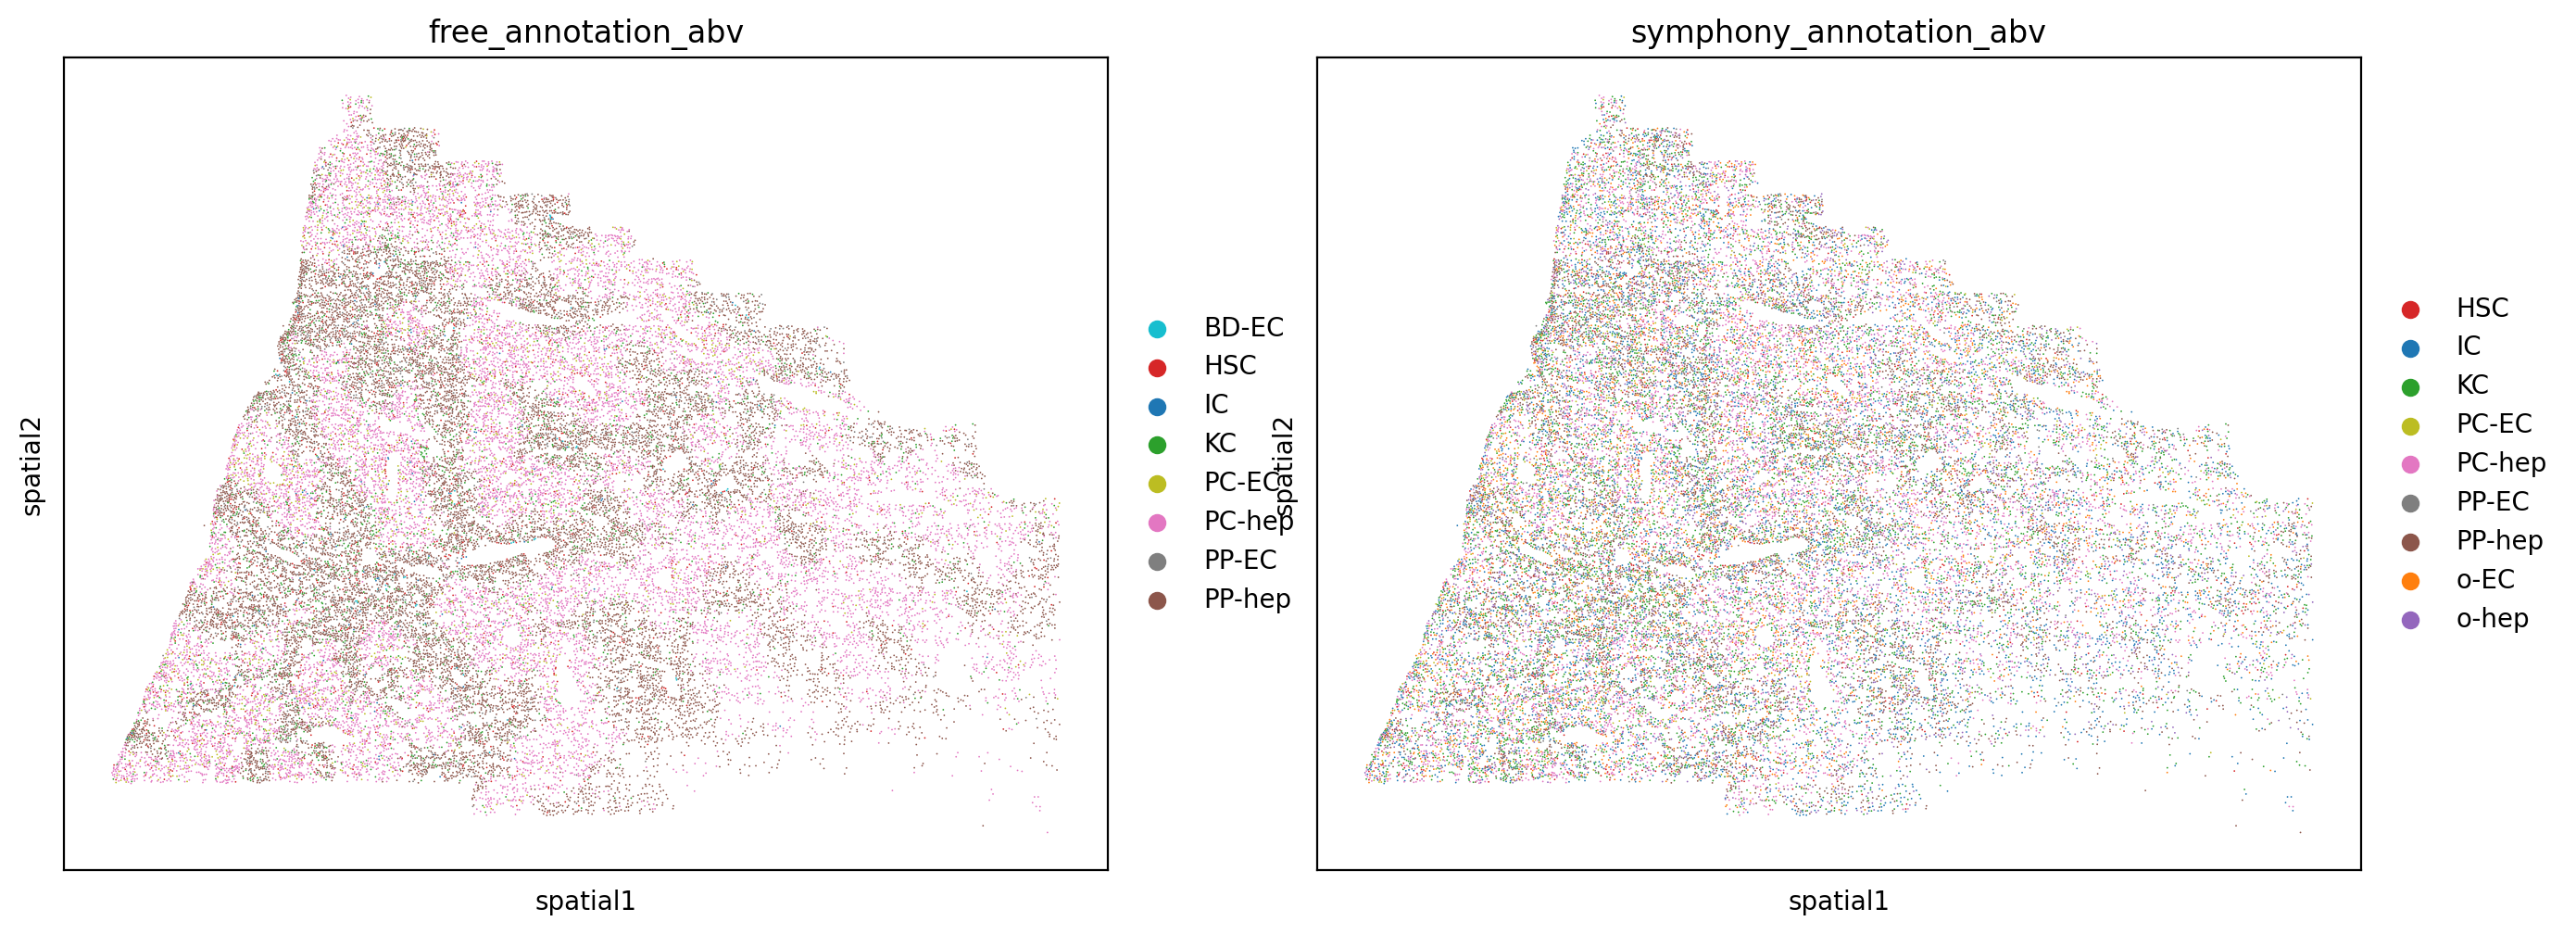

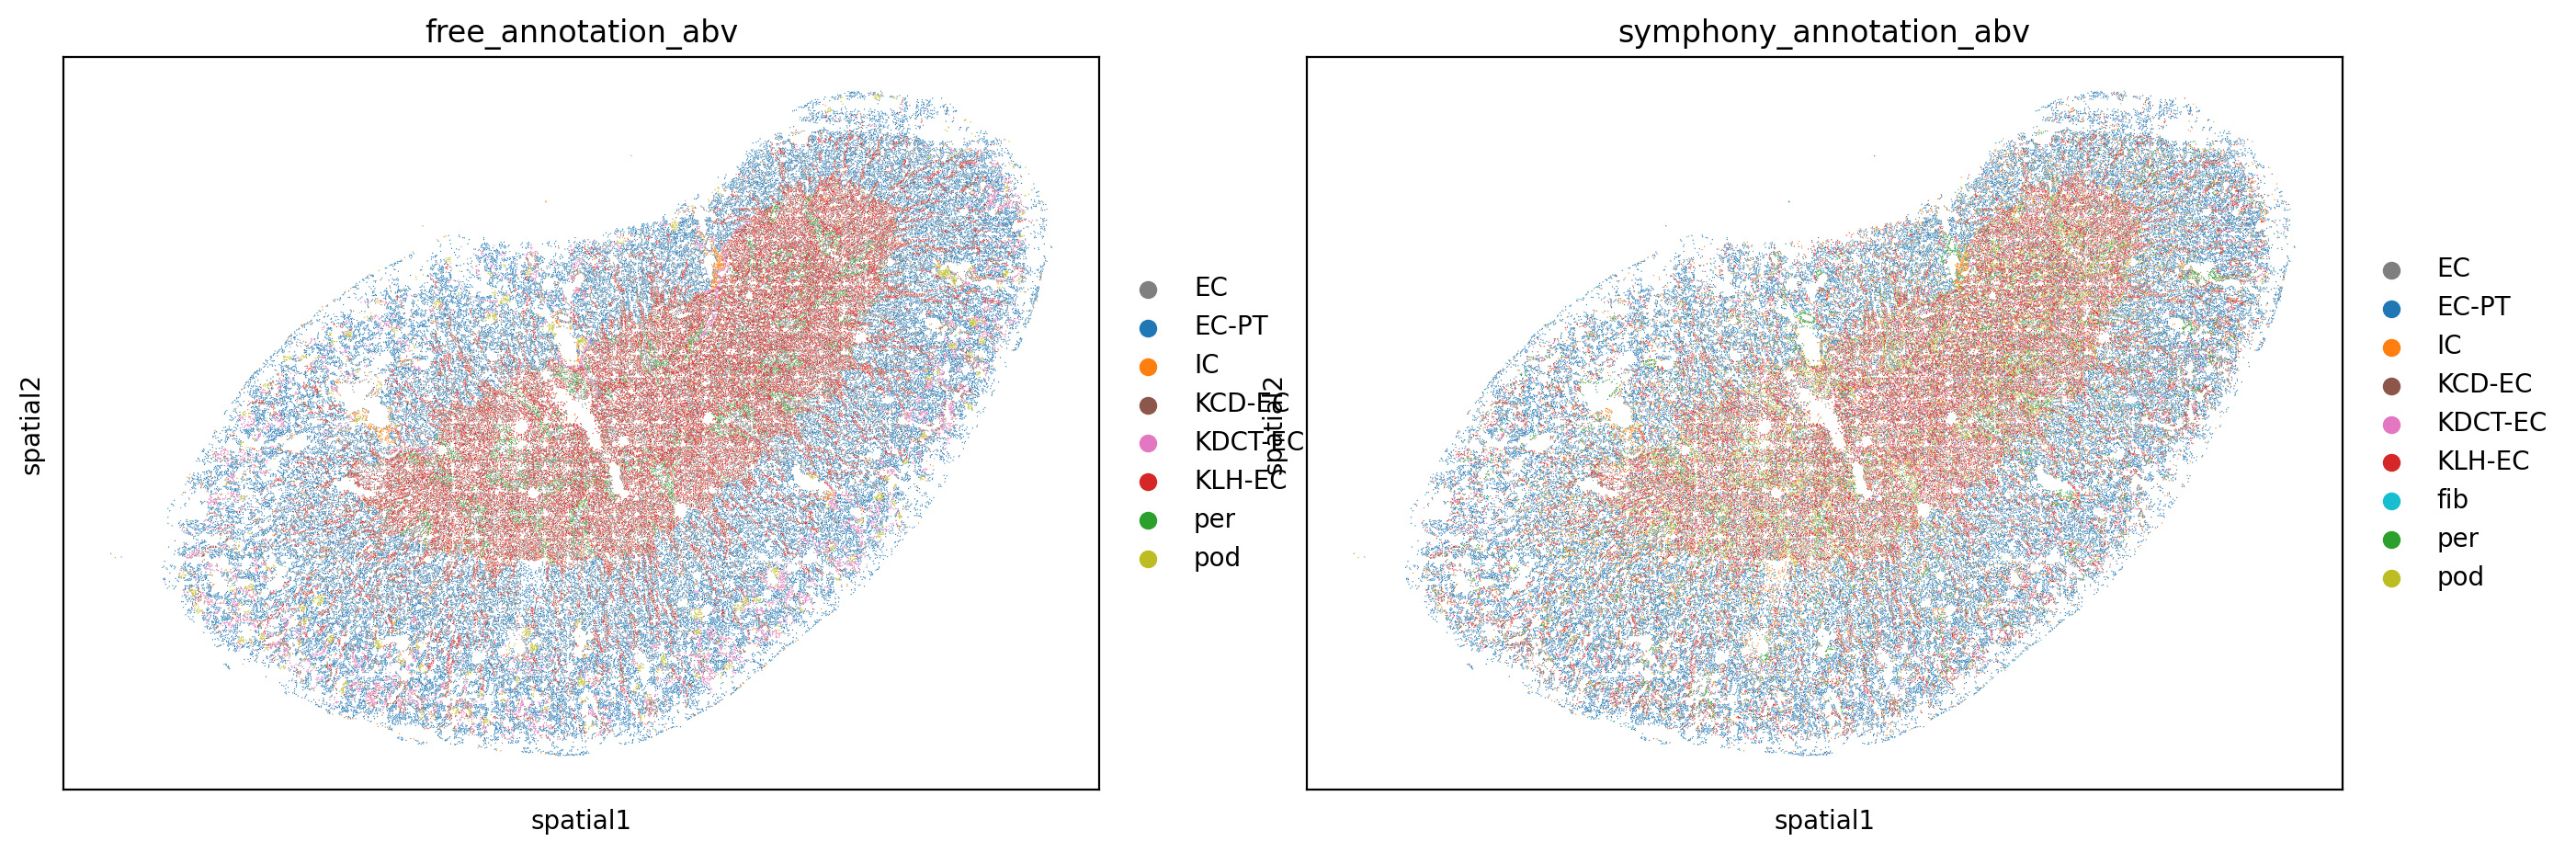

In [268]:
# Plot spatial plots

# liver
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Use the same colormap for the cell types between methods
colormap_liver = {list(liver_abbrev_map.values())[x]:
                 mpl.cm.get_cmap('tab10',len(list(liver_abbrev_map.values())))(x) for x in
                 range(len(list(liver_abbrev_map.values())))}

ax = axes[0]
sc.pl.spatial(manual_liver, color='free_annotation_abv', spot_size=10, ax=ax, show=False,
             palette=colormap_liver)
ax = axes[1]
sc.pl.spatial(manual_liver, color='symphony_annotation_abv', spot_size=10, ax=ax, show=False,
             palette=colormap_liver)

# kidney
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Use the same colormap for the cell types between methods
colormap_kidney = {list(kidney_abbrev_map.values())[x]:
                 mpl.cm.get_cmap('tab10',len(list(kidney_abbrev_map.values())))(x) for x in
                 range(len(list(kidney_abbrev_map.values())))}

ax = axes[0]
sc.pl.spatial(manual_kidney, color='free_annotation_abv', spot_size=10, ax=ax, show=False,
             palette=colormap_kidney)
ax = axes[1]
sc.pl.spatial(manual_kidney, color='symphony_annotation_abv', spot_size=10, ax=ax, show=False,
             palette=colormap_kidney)

<AxesSubplot:>

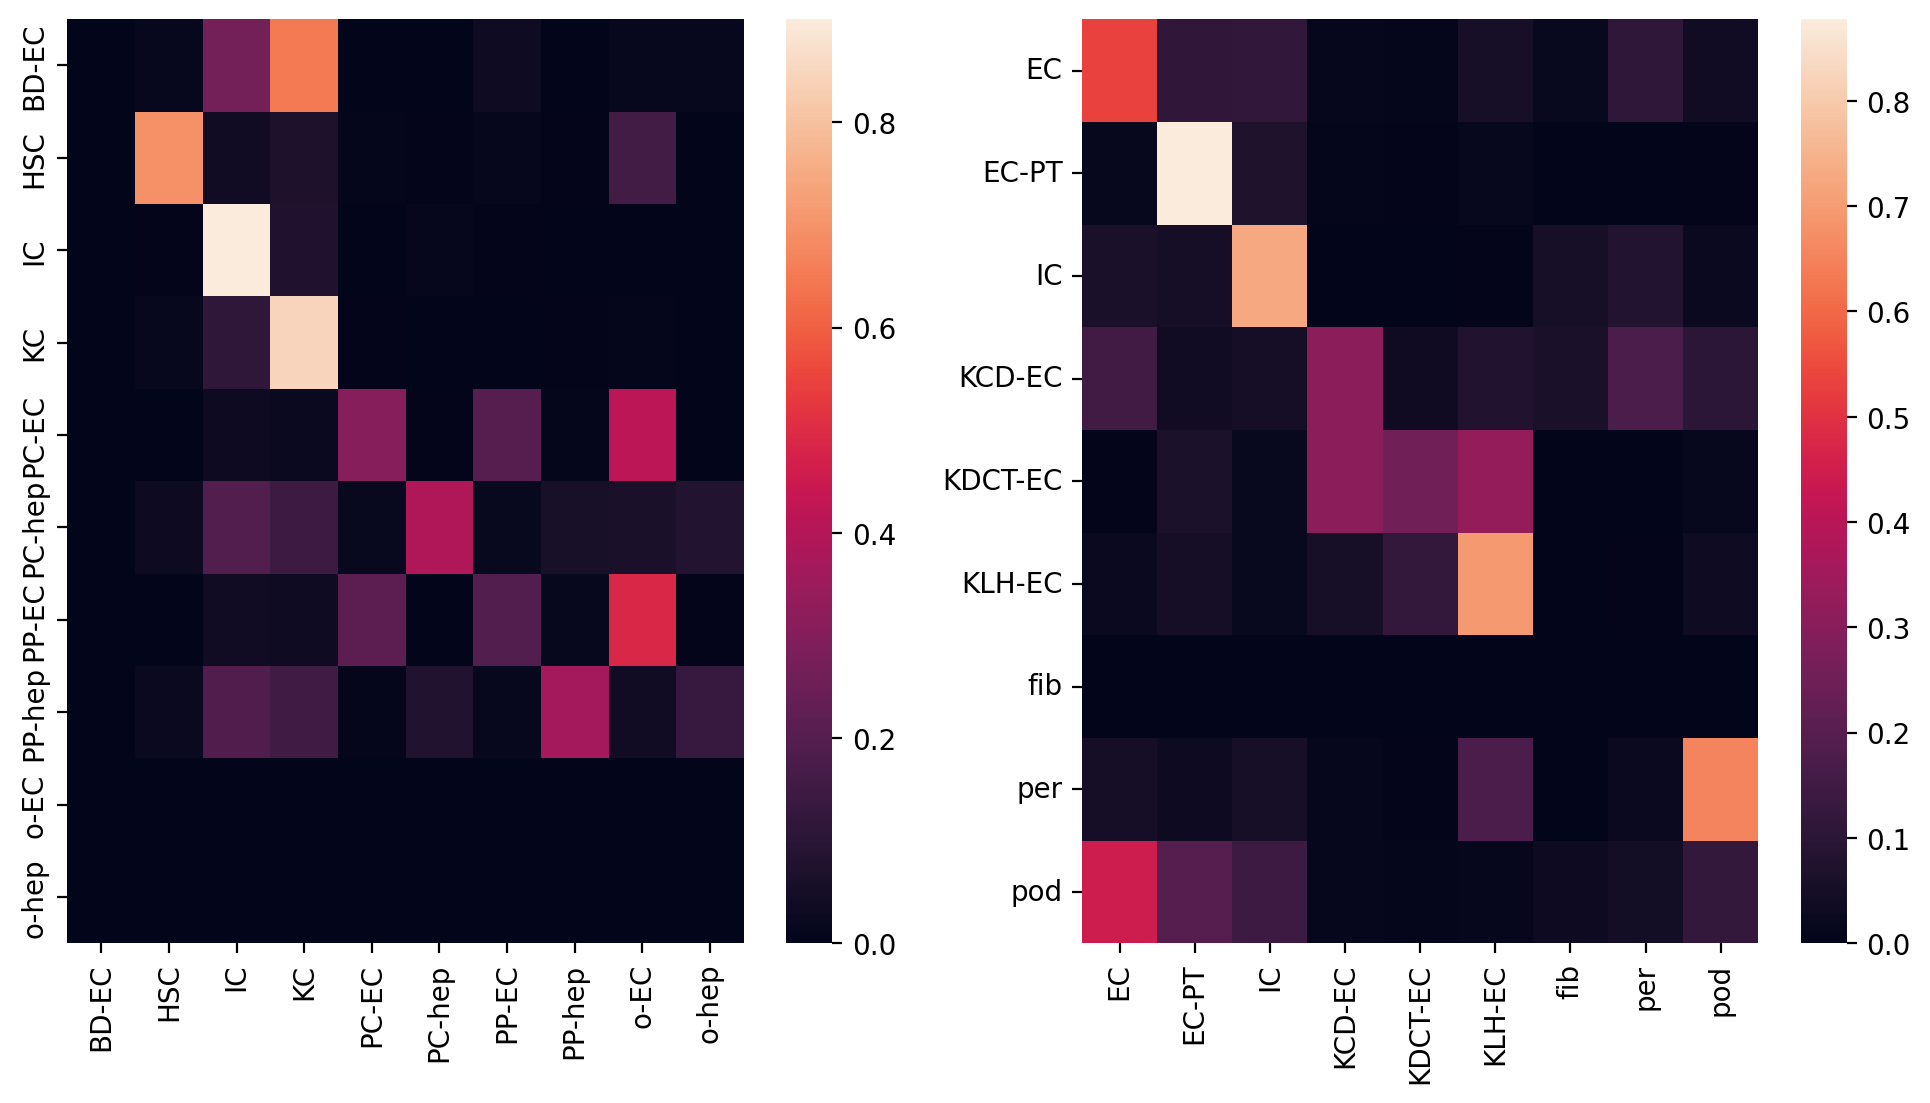

In [269]:
# Calculate confusion matrices
liver_celltypes = np.union1d(annot_liver['manual_abv'].unique(),
                             annot_liver['symphony_abv'].unique())
liver_confusion = pd.DataFrame(index=liver_celltypes,
                               columns=liver_celltypes,
                               data=confusion_matrix(annot_liver['manual_abv'],
                                                     annot_liver['symphony_abv'],
                                                     labels=liver_celltypes,
                                                     normalize='true'))
kidney_celltypes = np.union1d(annot_kidney['manual_abv'].unique(),
                              annot_kidney['symphony_abv'].unique())
kidney_confusion = pd.DataFrame(index=kidney_celltypes,
                               columns=kidney_celltypes,
                               data=confusion_matrix(annot_kidney['manual_abv'],
                                                     annot_kidney['symphony_abv'],
                                                     labels=kidney_celltypes,
                                                     normalize='true'))

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes[0]
sns.heatmap(liver_confusion, ax=ax)

ax = axes[1]
sns.heatmap(kidney_confusion, ax=ax)


In [270]:
symphony_liver

fov         volume      center_x      center_y         min_x  \
Unnamed: 0                                                                 
79          NaN  131801.930691  38385.087222   3830.896267  38299.391204   
83          NaN  108851.000059  38509.648904   3875.023162  38435.170597   
86          NaN   89270.962484  38290.840259   3909.486730  38228.403990   
90          NaN   72754.461865  38476.278879   3968.778575  38412.238598   
91          NaN   32280.005798  38219.940797   4006.663258  38181.324071   
...         ...            ...           ...           ...           ...   
82515       NaN   93787.803745  35915.153086  56614.199562  35859.138788   
82520       NaN  110537.098480  35433.239714  56706.150024  35376.407517   
82524       NaN  129565.160712  34932.197566  56777.057156  34875.063013   
82525       NaN  106176.969275  36096.352732  56772.910669  36033.415692   
82533       NaN  158610.672640  34804.912670  57047.536377  34730.160195   

                   min_y         max_x         max_y  barcodeCount  \
Unnamed: 0                                                           
79           3755.753711  38462.262006   3893.000000           289   
83           3811.620121  38580.026192   3943.565070           391   
86           3857.574182  38350.226270   3960.977006           181   
90           3921.448728  38546.764135   4011.138040           210   
91           3953.887765  38292.473600   4034.001966           108   
...                  ...           ...           ...           ...   
82515       56554.332080  35969.936758  56672.930338            90   
82520       56638.184889  35492.455257  56769.256527           103   
82524       56700.462187  34990.937867  56853.961228           102   
82525       56713.332080  36160.817553  56827.933039            97   
82533       56968.342428  34878.770173  57122.781329           106   

            average_DAPI_score         area  n_counts      cell_type_pred_knn  \
Unnamed: 0                                                                      
79                 5292.381008  1581.597436       289        other hepatocyte   
83                 4565.679348  1306.190752       391  pericentral hepatocyte   
86                 5144.508212  1071.234121       181  pericentral hepatocyte   
90                 3167.122601   873.039340       210       myeloid leukocyte   
91                 2934.364650   387.353768       108                 NK cell   
...                        ...          ...       ...                     ...   
82515             11672.705454  1125.435334        90        other hepatocyte   
82520             11945.799153  1326.423597       103                  B cell   
82524              9880.052785  1554.756634       102   periportal hepatocyte   
82525             10758.281864  1274.102900        97   periportal hepatocyte   
82533             10576.048450  1903.297103       106                  B cell   

            cell_type_pred_knn_prob  
Unnamed: 0                           
79                              0.6  
83                              0.6  
86                              0.8  
90                              0.8  
91                              1.0  
...                             ...  
82515                           0.6  
82520                           0.6  
82524                           0.4  
82525                           1.0  
82533                           0.6  

[34217 rows x 14 columns]

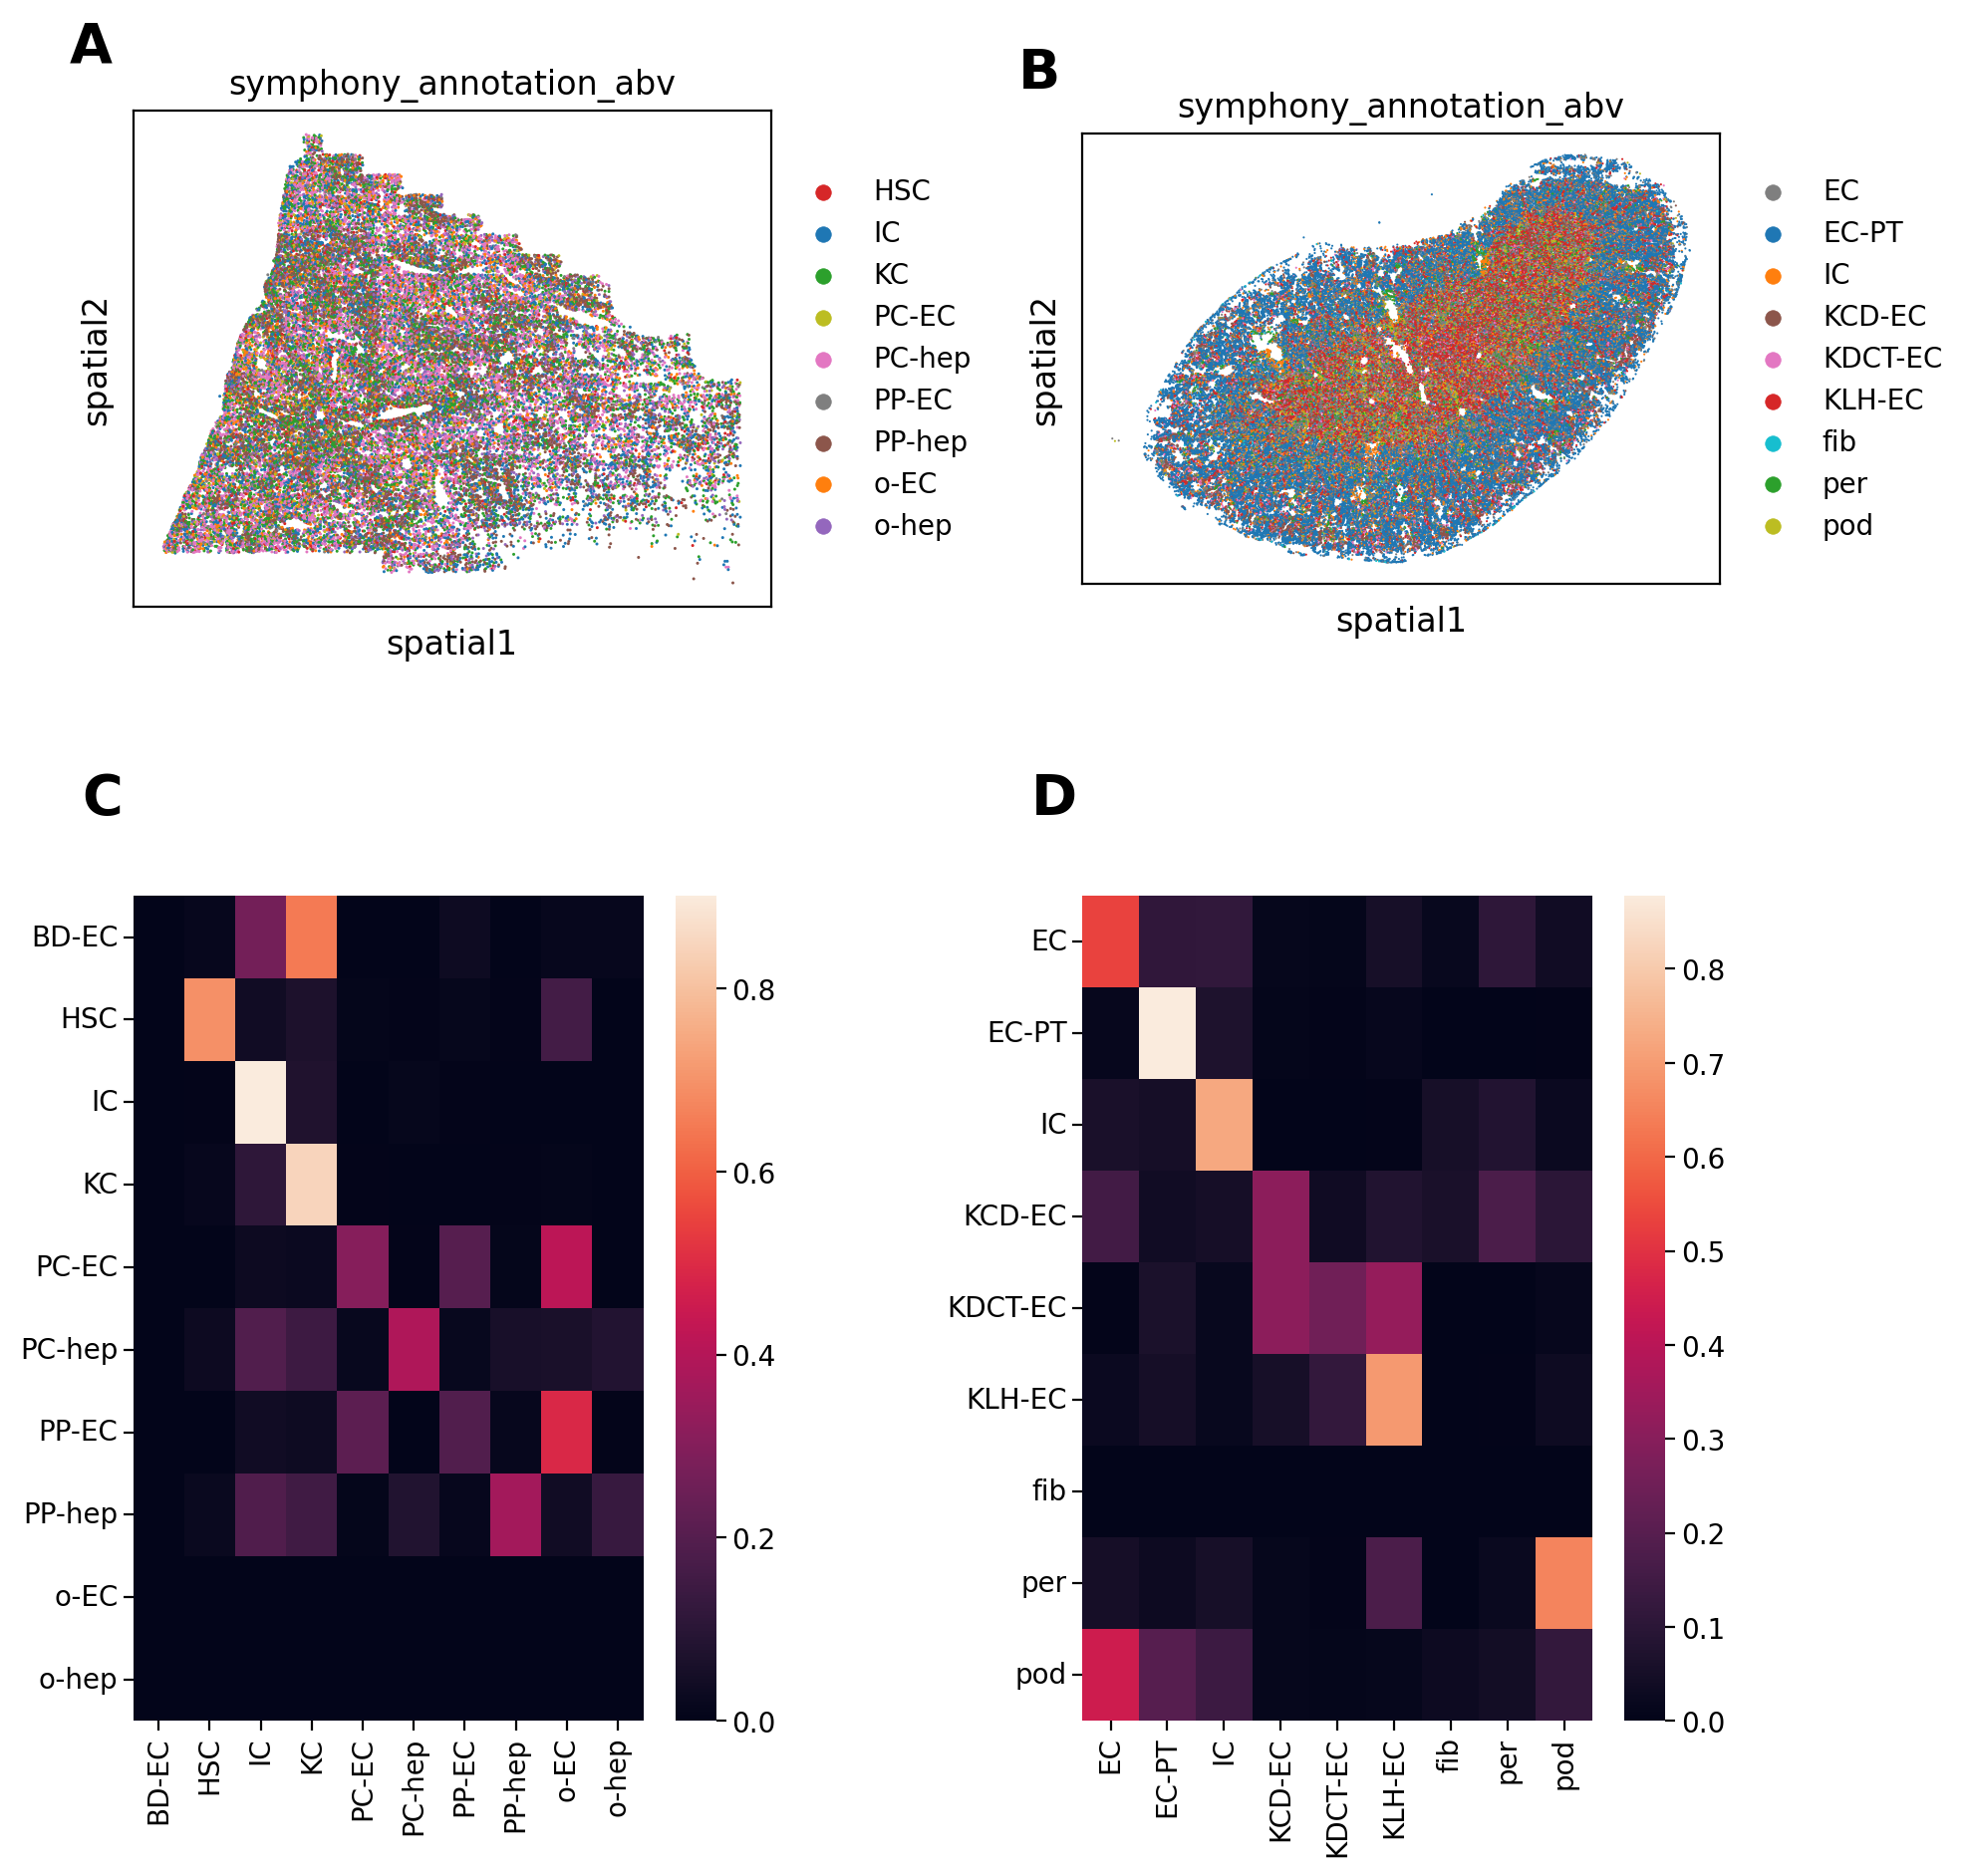

In [276]:
# Plot combined figure
sc.set_figure_params(vector_friendly=True, dpi=300, dpi_save=2000)
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
set_plotting_style()

fig, axes = plt.subplots(2, 2, figsize=(10,10))

# liver spatial plot
ax = axes[0,0]
sc.pl.spatial(manual_liver, color='symphony_annotation_abv', spot_size=30, ax=ax, show=False,
             palette=colormap_liver)

# kidney spatial plot
ax = axes[0,1]
sc.pl.spatial(manual_kidney, color='symphony_annotation_abv', spot_size=30, ax=ax, show=False,
             palette=colormap_kidney)

# liver confusion matrix
ax = axes[1,0]
sns.heatmap(liver_confusion, ax=ax)

# kidney confusion matrix
ax = axes[1,1]
sns.heatmap(kidney_confusion, ax=ax)

# Label subpanels
axes_flat = axes.flat
for n, ax in enumerate(axes_flat):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
plt.show()

In [277]:
# Export figures
fig.savefig('../../figures/SIFig_symphony_integration.svg', transparent=True)
fig.savefig('../../figures/SIFig_symphony_integration.png', transparent=True)

print('Figures saved.')

Figures saved.
